In [1]:
import numpy as np
import pandas as pd
import joblib
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
import os
import sys
from pathlib import Path

path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))

from src.data.save_results import save_model_scores, save_model_predictions
from src.utils.data_loader import load_preprocessed_data

import matplotlib.pyplot as plt

In [2]:
DATA = path / "data"
TRAINED_DATA = DATA / "trained_data"
MODELS = DATA / "models"


In [ ]:
METHOD = "SingleOutput"

# Define multiple scorings
cv_scorings = {
    "CV RMSE": "neg_root_mean_squared_error",
    "CV MAE": "neg_mean_absolute_error",
    "CV R2": "r2"
}

target_variables = [
    "temperature_2m",
    "apparent_temperature",
    "relative_humidity_2m",
    "wind_speed_10m",
    "wind_direction_10m_sin",
    "wind_direction_10m_cos",
    "rain",
    "shortwave_radiation"
]

for target_variable in target_variables:
    data = load_preprocessed_data(method=METHOD, target_variable=target_variable)

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    preprocessor = data["preprocessor"]

    # Pipeline cho lgbmr
    lgbmr_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", LGBMRegressor(objective="regression", n_estimators=100, random_state=42))
    ])

    tscv = TimeSeriesSplit(n_splits=5)

    # Dictionary to store CV results
    cv_results = {}

    for name, scoring in cv_scorings.items():
        scores = cross_val_score(
            lgbmr_pipeline, X_train, y_train,
            cv=tscv, scoring=scoring
        )
        mean_score = -np.mean(scores) if "neg_" in scoring else np.mean(scores)
        std_score = np.std(scores)
        cv_results[name] = (mean_score, std_score)

    # Train and evaluate on test set
    MODEL_PATH = MODELS / "LightGBMRegressor"
    if not MODEL_PATH.exists():
        MODEL_PATH.mkdir(parents=True, exist_ok=True)
    MODEL_TARGET_PATH = MODEL_PATH / f"LGBMR_{target_variable}.pkl"
    if MODEL_TARGET_PATH.exists():
        lgbmr_pipeline = joblib.load(MODEL_TARGET_PATH)
    else:
        # Train and evaluate on test set
        lgbmr_pipeline.fit(X_train, y_train)
        joblib.dump(lgbmr_pipeline, MODEL_TARGET_PATH)
    
    y_pred_lgbmr = lgbmr_pipeline.predict(X_test)

    mae_lgbmr = mean_absolute_error(y_test, y_pred_lgbmr)
    rmse_lgbmr = np.sqrt(mean_squared_error(y_test, y_pred_lgbmr))
    r2_lgbmr = r2_score(y_test, y_pred_lgbmr)

    y_train_pred = lgbmr_pipeline.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Transform X_train via preprocessor to calculate VIF
    X_train_transformed = preprocessor.fit_transform(X_train)
    if hasattr(X_train_transformed, "toarray"):
        X_train_transformed = X_train_transformed.toarray()

    X_vif = pd.DataFrame(X_train_transformed)
    vif_data = pd.DataFrame()
    vif_data["feature_index"] = range(X_vif.shape[1])
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

    # === Print results ===
    print(f"[RESULT] Light GBM Regressor - {target_variable}")
    print("Cross-Validation Scores:")
    for name, (mean_score, std_score) in cv_results.items():
        print(f"  [{name}]: {mean_score:.2f} ± {std_score:.2f}")
    print("\nTest Set Evaluation:")
    print(f"  [MAE]: {mae_lgbmr:.2f}")
    print(f"  [RMSE]: {rmse_lgbmr:.2f}")
    print(f"  [Train R2 Score]: {r2_train:.2f}")
    print(f"  [Test R2 Score]: {r2_lgbmr:.2f}")
    print("\n[VIF Scores]")
    print(vif_data.sort_values("VIF", ascending=False).head(20))

    # === Save results ===
    PATH = DATA / "scores&predictions" / METHOD / target_variable
    save_model_scores(
        "LightGBMRegressor",
        PATH,
        mae_lgbmr,
        rmse_lgbmr,
        r2_lgbmr,
        cv_results["CV RMSE"][0],  # mean RMSE
        cv_results["CV RMSE"][1],  # std RMSE
        cv_results["CV MAE"][0],  # mean MAE
        cv_results["CV MAE"][1],  # std MAE
        cv_results["CV R2"][0],  # mean R2
        cv_results["CV R2"][1],  # std R2
    )
    save_model_predictions("LightGBMRegressor", y_test, y_pred_lgbmr, PATH)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 23.346327


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 23.312128


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 23.152913


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 23.131339


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 23.194751


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 23.346327


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 23.312128


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 23.152913


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 23.131339


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 23.194751


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 23.346327


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 23.312128


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 23.152913


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 23.131339


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 23.194751


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 23.225665


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - temperature_2m
Cross-Validation Scores:
  [CV RMSE]: 2.59 ± 0.06
  [CV MAE]: 1.93 ± 0.05
  [CV R2]: 0.80 ± 0.01

Test Set Evaluation:
  [MAE]: 1.97
  [RMSE]: 2.62
  [Train R2 Score]: 0.83
  [Test R2 Score]: 0.79

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 1

c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 26.271120


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 26.045158


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.393760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 26.049285


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 26.158744


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 26.320498


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 26.271120


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 26.045158


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 26.049285


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 26.158744


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 26.320498


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 26.271120


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 26.045158


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 26.049285


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 26.158744


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 26.198860


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - apparent_temperature
Cross-Validation Scores:
  [CV RMSE]: 3.75 ± 0.07
  [CV MAE]: 2.82 ± 0.06
  [CV R2]: 0.79 ± 0.00

Test Set Evaluation:
  [MAE]: 2.90
  [RMSE]: 3.83
  [Train R2 Score]: 0.83
  [Test R2 Score]: 0.79

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 79.973598


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 79.768098


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 79.542967


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 79.690156


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 79.809090


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 79.973598


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 79.768098


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 79.542967


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 79.690156


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 79.809090


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 79.973598


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 79.768098


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 79.542967


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 79.690156


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 79.809090


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 79.686737


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - relative_humidity_2m
Cross-Validation Scores:
  [CV RMSE]: 7.80 ± 0.49
  [CV MAE]: 5.86 ± 0.35
  [CV R2]: 0.70 ± 0.03

Test Set Evaluation:
  [MAE]: 6.02
  [RMSE]: 8.02
  [Train R2 Score]: 0.74
  [Test R2 Score]: 0.68

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used featu

c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 7.521927


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 7.515496


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 7.467706


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 7.439100


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 7.394336


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 7.521927


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 7.515496


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 7.467706


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 7.439100


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 7.394336


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 7.521927


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 7.515496


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 7.467706


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 7.439100


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 7.404479


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - wind_speed_10m
Cross-Validation Scores:
  [CV RMSE]: 1.52 ± 0.03
  [CV MAE]: 1.10 ± 0.02
  [CV R2]: 0.84 ± 0.01

Test Set Evaluation:
  [MAE]: 1.47
  [RMSE]: 2.05
  [Train R2 Score]: 0.85
  [Test R2 Score]: 0.78

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 0.307161


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 0.297101


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 0.283715


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 0.279990


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 0.276049


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 0.307161


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 0.297101


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 0.283715


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 0.279990


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 0.276049


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 0.307161


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 0.297101


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 0.283715


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 0.279990


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 0.276049


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 0.274609


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - wind_direction_10m_sin
Cross-Validation Scores:
  [CV RMSE]: 0.15 ± 0.00
  [CV MAE]: 0.08 ± 0.00
  [CV R2]: 0.93 ± 0.00

Test Set Evaluation:
  [MAE]: 0.08
  [RMSE]: 0.16
  [Train R2 Score]: 0.93
  [Test R2 Score]: 0.91

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1966
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 13
[LightGBM] [Info] Start training from score -0.072123


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1977
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 13
[LightGBM] [Info] Start training from score -0.086832


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 14
[LightGBM] [Info] Start training from score -0.059191


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 14
[LightGBM] [Info] Start training from score -0.040078


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1986
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 14
[LightGBM] [Info] Start training from score -0.034305


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1966
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 13
[LightGBM] [Info] Start training from score -0.072123


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1977
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 13
[LightGBM] [Info] Start training from score -0.086832


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 14
[LightGBM] [Info] Start training from score -0.059191


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 14
[LightGBM] [Info] Start training from score -0.040078


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1986
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 14
[LightGBM] [Info] Start training from score -0.034305


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1966
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 13
[LightGBM] [Info] Start training from score -0.072123


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1977
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 13
[LightGBM] [Info] Start training from score -0.086832


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 14
[LightGBM] [Info] Start training from score -0.059191


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 14
[LightGBM] [Info] Start training from score -0.040078


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1986
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 14
[LightGBM] [Info] Start training from score -0.034305


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 14
[LightGBM] [Info] Start training from score -0.029907


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - wind_direction_10m_cos
Cross-Validation Scores:
  [CV RMSE]: 0.14 ± 0.00
  [CV MAE]: 0.06 ± 0.00
  [CV R2]: 0.97 ± 0.00

Test Set Evaluation:
  [MAE]: 0.07
  [RMSE]: 0.15
  [Train R2 Score]: 0.97
  [Test R2 Score]: 0.96

[VIF Scores]
    feature_index       VIF
1               1  3.518548
2               2  2.956874
3               3  2.794677
0               0  2.661707
9               9  2.575252
8               8  2.536658
10             10  2.143972
6               6  2.048778
7               7  1.811931
13             13  1.804813
4               4  1.493721
11             11  1.472117
5               5  1.247410
12             12  1.160987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start tr

c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 0.187446


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 0.191306


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 0.197875


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 0.200013


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 0.178629


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 0.187446


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 0.191306


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 0.197875


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 0.200013


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 0.178629


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 0.187446


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 0.191306


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 0.197875


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 0.200013


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 0.195874


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - rain
Cross-Validation Scores:
  [CV RMSE]: 0.62 ± 0.03
  [CV MAE]: 0.21 ± 0.01
  [CV R2]: 0.30 ± 0.02

Test Set Evaluation:
  [MAE]: 0.27
  [RMSE]: 0.81
  [Train R2 Score]: 0.39
  [Test R2 Score]: 0.23

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGB

c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 157.650201


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 156.636376


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 155.455498


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 155.008824


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 158.317794


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 157.650201


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 156.636376


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 155.455498


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 155.008824


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 99703, number of used features: 12
[LightGBM] [Info] Start training from score 158.317794


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 199403, number of used features: 12
[LightGBM] [Info] Start training from score 157.650201


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 299103, number of used features: 13
[LightGBM] [Info] Start training from score 156.636376


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 398803, number of used features: 13
[LightGBM] [Info] Start training from score 155.455498


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 498503, number of used features: 13
[LightGBM] [Info] Start training from score 155.008824


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 598203, number of used features: 13
[LightGBM] [Info] Start training from score 155.219987


c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ADMIN\MyProject\School_Projects\WeatherForecastML-DM\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[RESULT] Light GBM Regressor - shortwave_radiation
Cross-Validation Scores:
  [CV RMSE]: 76.25 ± 1.22
  [CV MAE]: 45.68 ± 1.56
  [CV R2]: 0.89 ± 0.00

Test Set Evaluation:
  [MAE]: 46.91
  [RMSE]: 83.25
  [Train R2 Score]: 0.90
  [Test R2 Score]: 0.87

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703


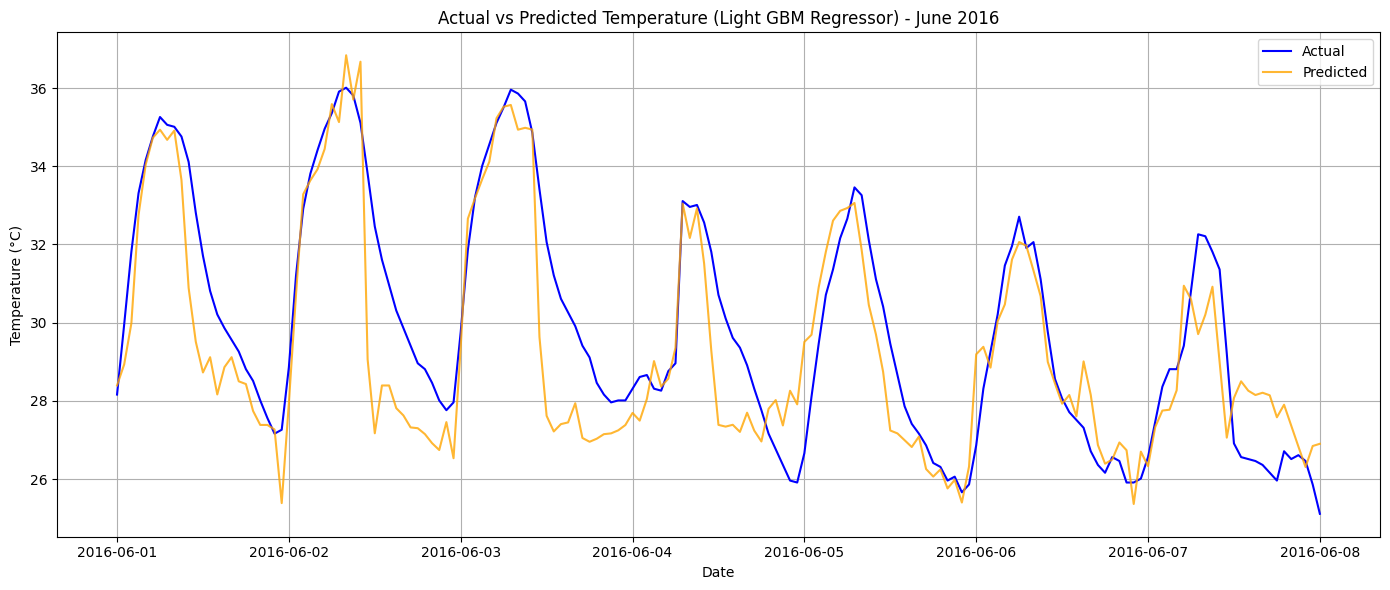

In [4]:
# Đọc dữ liệu và chuyển đổi cột date
test_df = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/temperature_2m/test_df.csv", parse_dates=["date"])
model_predictions = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/temperature_2m/model_predictions.csv")

# Kiểm tra điều kiện: actual == temperature_2m_max
matching = model_predictions["actual"].values == test_df["temperature_2m"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions["date"] = np.where(
    matching,
    test_df["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions["date"] = pd.to_datetime(model_predictions["date"], errors="coerce")

# Lọc khoảng thời gian từ 01/01/2016 đến 31/12/2016
mask = (model_predictions["date"] >= "2016-06-01") & (model_predictions["date"] <= "2016-06-08")
subset_df = model_predictions[mask]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(subset_df["date"], subset_df["actual"], label="Actual", color="blue")
plt.plot(subset_df["date"], subset_df["LightGBMRegressor_pred"], label="Predicted", color="orange", alpha=0.8)
plt.title("Actual vs Predicted Temperature (Light GBM Regressor) - June 2016")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


[MAE]: 0.20 rad ~ 11.34°
[RMSE]: 0.76 rad ~ 43.43°
[R2]: 0.76


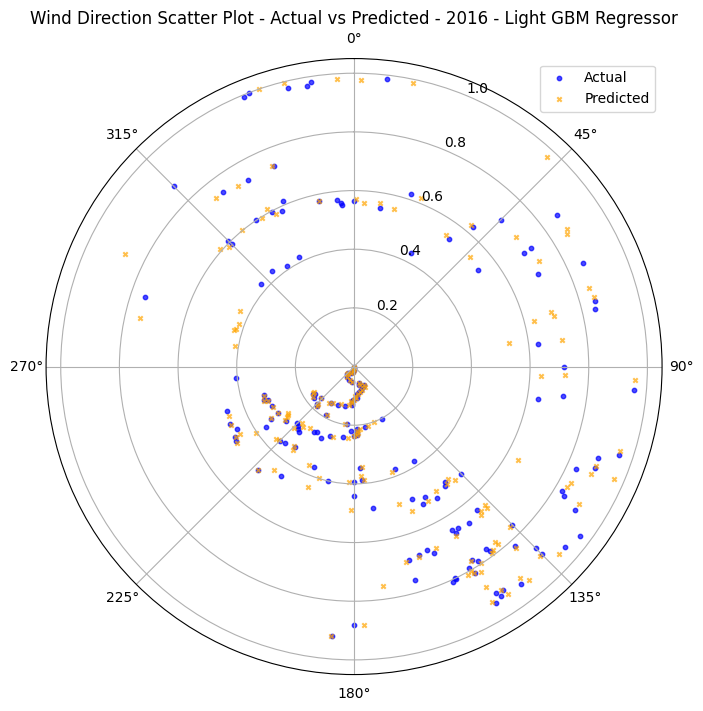

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

matching = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_sin["date"] = np.where(
    matching,
    test_df_sin["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

matching = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_cos["date"] = np.where(
    matching,
    test_df_cos["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Chuyển hướng gió sang radian
theta_actual = np.arctan2(model_predictions_sin["actual"], model_predictions_cos["actual"])
theta_pred = np.arctan2(model_predictions_sin["LightGBMRegressor_pred"],
                        model_predictions_cos["LightGBMRegressor_pred"])

mae_wind_direction_10m = mean_absolute_error(theta_actual, theta_pred)
rmse_wind_direction_10m = np.sqrt(mean_squared_error(theta_actual, theta_pred))
r2_wind_direction_10m = r2_score(theta_actual, theta_pred)

print(f"[MAE]: {mae_wind_direction_10m:.2f} rad ~ {mae_wind_direction_10m * 180 / np.pi:.2f}°")
print(f"[RMSE]: {rmse_wind_direction_10m:.2f} rad ~ {rmse_wind_direction_10m * 180 / np.pi:.2f}°")
print(f"[R2]: {r2_wind_direction_10m:.2f}")

mask = (model_predictions_sin["date"] >= "2016-06-01") & (model_predictions_sin["date"] <= "2016-06-08")
theta_actual = theta_actual[mask]
theta_pred = theta_pred[mask]
# Dùng bán kính là chỉ số thời gian hoặc ngẫu nhiên để dễ nhìn
r = np.linspace(0, 1, len(theta_actual))

# Vẽ scatter
plt.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.7)
plt.scatter(theta_pred, r, c='orange', s=10, label="Predicted", alpha=0.7, marker='x')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction Scatter Plot - Actual vs Predicted - 2016 - Light GBM Regressor")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

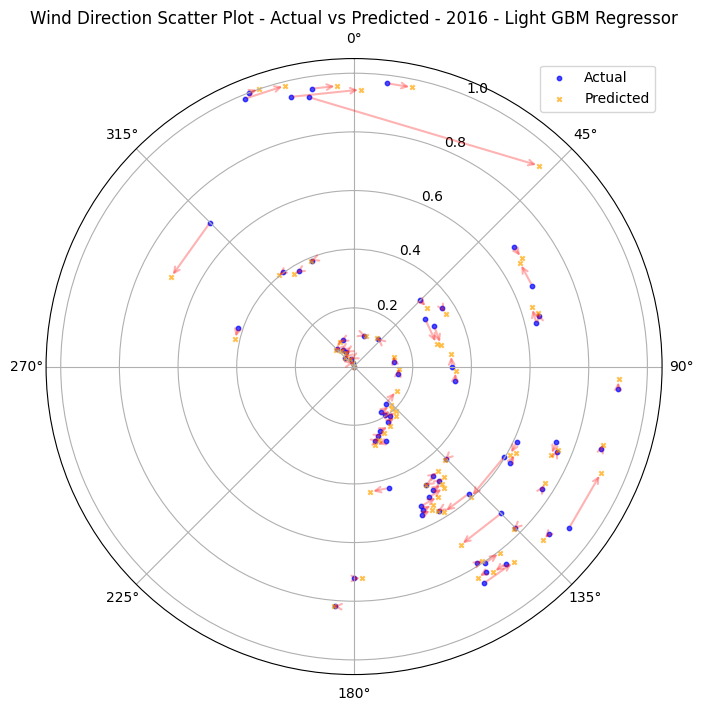

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

matching = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_sin["date"] = np.where(
    matching,
    test_df_sin["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

matching = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_cos["date"] = np.where(
    matching,
    test_df_cos["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Chuyển hướng gió sang radian
theta_actual = np.arctan2(model_predictions_sin["actual"], model_predictions_cos["actual"])
theta_pred = np.arctan2(model_predictions_sin["LightGBMRegressor_pred"],
                        model_predictions_cos["LightGBMRegressor_pred"])

mask = (model_predictions_sin["date"] >= "2016-06-05") & (model_predictions_sin["date"] <= "2016-06-08")
theta_actual = theta_actual[mask]
theta_pred = theta_pred[mask]
# Dùng bán kính là chỉ số thời gian hoặc ngẫu nhiên để dễ nhìn
r = np.linspace(0, 1, len(theta_actual))

for actual, pred, radius in zip(theta_actual, theta_pred, r):
    ax.annotate(
        '',
        xy=(pred, radius),          # Điểm kết thúc (predicted)
        xytext=(actual, radius),    # Điểm bắt đầu (actual)
        arrowprops=dict(
            arrowstyle='->', 
            color='red',
            alpha=0.3,
            lw=1.5
        )
    )

# Vẽ scatter
plt.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.7)
plt.scatter(theta_pred, r, c='orange', s=10, label="Predicted", alpha=0.7, marker='x')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction Scatter Plot - Actual vs Predicted - 2016 - Light GBM Regressor")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()